# Tau Classification Results Analysis

Analyze the output from OmniLearned evaluation.

**Primary task (2-class):** Tau vs QCD only. Class 0=QCD, 1=Tau. Electron jets are excluded from primary metrics (use auxiliary electron_vs_qcd for QCD vs Electron).

**Auxiliary tasks:** decay_mode (1-prong vs 3-prong, tau only), electron_vs_qcd (QCD vs Electron).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay,
    roc_curve, 
    auc,
    classification_report,
    accuracy_score
)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

## 1. Load Results

In [ ]:
# Load the evaluation output
results_path = "../results/outputs__tau_0.npz"
data = np.load(results_path)

print("Available arrays:", list(data.keys()))

# Extract predictions and labels
predictions = data['prediction']  # Shape: [N_jets, 3] - softmax probabilities
true_labels = data['pid']         # Shape: [N_jets] - true class labels

print(f"\nPredictions shape: {predictions.shape}")
print(f"Labels shape: {true_labels.shape}")
print(f"Total jets: {len(true_labels)}")

Available arrays: ['prediction', 'pid', 'cond', 'aux_decay_mode_pred', 'aux_electron_vs_qcd_pred', 'decay_mode']

Predictions shape: (24427, 3)
Labels shape: (24427,)
Total jets: 24427


In [3]:
# Class names mapping
class_names = ['QCD', 'Tau', 'Electron']

# Get predicted classes (argmax of probabilities)
pred_labels = np.argmax(predictions, axis=1)

# Count samples per class
print("Sample distribution:")
for i, name in enumerate(class_names):
    n_true = np.sum(true_labels == i)
    n_pred = np.sum(pred_labels == i)
    print(f"  {name}: {n_true} true, {n_pred} predicted")

Sample distribution:
  QCD: 15191 true, 13234 predicted
  Tau: 6664 true, 7855 predicted
  Electron: 2572 true, 3338 predicted


## 2. Overall Accuracy

In [4]:
# Calculate overall accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Per-class accuracy
print("\nPer-class Accuracy:")
for i, name in enumerate(class_names):
    mask = true_labels == i
    if mask.sum() > 0:
        class_acc = (pred_labels[mask] == i).mean()
        print(f"  {name}: {class_acc:.4f} ({class_acc*100:.2f}%)")

Overall Accuracy: 0.7673 (76.73%)

Per-class Accuracy:
  QCD: 0.7884 (78.84%)
  Tau: 0.6859 (68.59%)
  Electron: 0.8530 (85.30%)


## 3. Classification Report

In [5]:
# Detailed classification report
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))

              precision    recall  f1-score   support

         QCD     0.9050    0.7884    0.8427     15191
         Tau     0.5819    0.6859    0.6297      6664
    Electron     0.6573    0.8530    0.7425      2572

    accuracy                         0.7673     24427
   macro avg     0.7147    0.7758    0.7383     24427
weighted avg     0.7908    0.7673    0.7740     24427



## 9. Prongness Analysis (Decay Mode: 1-prong vs 3-prong)

This auxiliary task classifies tau jets by their decay mode:
- 0 = 1-prong (single charged track)
- 3-prong (three charged tracks)

In [6]:
# Check if decay mode predictions are available
if 'aux_decay_mode_pred' in data.keys():
    decay_mode_pred = data['aux_decay_mode_pred']  # Shape: [N_jets, 2] - softmax probs
    decay_mode_true = data['decay_mode']            # Shape: [N_jets] - true labels
    
    print(f"Decay mode predictions shape: {decay_mode_pred.shape}")
    print(f"Decay mode labels shape: {decay_mode_true.shape}")
    
    # Filter for tau jets only (decay mode is only valid for taus)
    tau_mask = true_labels == 1
    valid_mask = tau_mask & (decay_mode_true >= 0)  # -1 means N/A
    
    print(f"\nTotal tau jets: {tau_mask.sum()}") 
    print(f"Tau jets with valid decay mode: {valid_mask.sum()}")
    
    # Get predictions and labels for valid tau jets
    dm_pred_valid = decay_mode_pred[valid_mask]
    dm_true_valid = decay_mode_true[valid_mask]
    dm_pred_labels = np.argmax(dm_pred_valid, axis=1)
    
    print(f"\\n1-prong taus: {(dm_true_valid == 0).sum()}")
    print(f"3-prong taus: {(dm_true_valid == 1).sum()}")
else:
    print("No auxiliary decay_mode predictions found in results.")
    print("Re-run evaluation after reinstalling: pip install -e . && omnilearned evaluate ...")
    print("Available keys:", list(data.keys()))

Decay mode predictions shape: (24427, 2)
Decay mode labels shape: (24427,)

Total tau jets: 6664
Tau jets with valid decay mode: 6658
\n1-prong taus: 4906
3-prong taus: 1752


Decay Mode Accuracy: 0.7622 (76.22%)

Decay Mode Classification Report:
              precision    recall  f1-score   support

     1-prong     0.7810    0.9413    0.8537      4906
     3-prong     0.6134    0.2608    0.3660      1752

    accuracy                         0.7622      6658
   macro avg     0.6972    0.6011    0.6099      6658
weighted avg     0.7369    0.7622    0.7254      6658



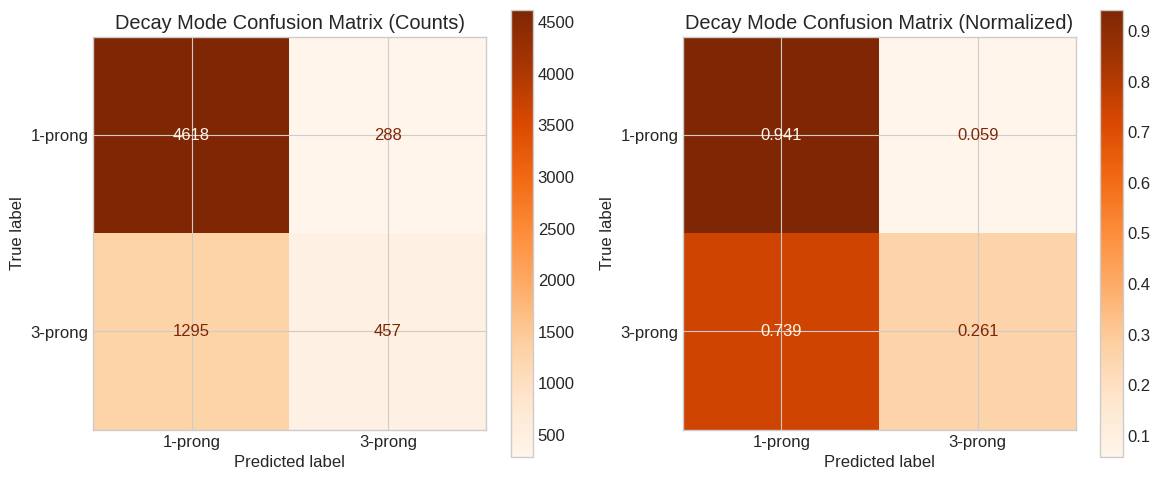

In [7]:
# Prongness metrics (only run if decay_mode is available)
if 'aux_decay_mode_pred' in data.keys():
    prong_names = ['1-prong', '3-prong']
    
    # Accuracy
    dm_accuracy = accuracy_score(dm_true_valid, dm_pred_labels)
    print(f"Decay Mode Accuracy: {dm_accuracy:.4f} ({dm_accuracy*100:.2f}%)")
    
    # Classification report
    print("\nDecay Mode Classification Report:")
    print(classification_report(dm_true_valid, dm_pred_labels, target_names=prong_names, digits=4))
    
    # Confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    cm_dm = confusion_matrix(dm_true_valid, dm_pred_labels)
    disp1 = ConfusionMatrixDisplay(cm_dm, display_labels=prong_names)
    disp1.plot(ax=axes[0], cmap='Oranges', values_format='d')
    axes[0].set_title('Decay Mode Confusion Matrix (Counts)')
    
    cm_dm_norm = cm_dm.astype('float') / cm_dm.sum(axis=1)[:, np.newaxis]
    disp2 = ConfusionMatrixDisplay(cm_dm_norm, display_labels=prong_names)
    disp2.plot(ax=axes[1], cmap='Oranges', values_format='.3f')
    axes[1].set_title('Decay Mode Confusion Matrix (Normalized)')
    
    plt.tight_layout()
    plt.savefig('../results/decay_mode_confusion.png', dpi=150, bbox_inches='tight')
    plt.show()

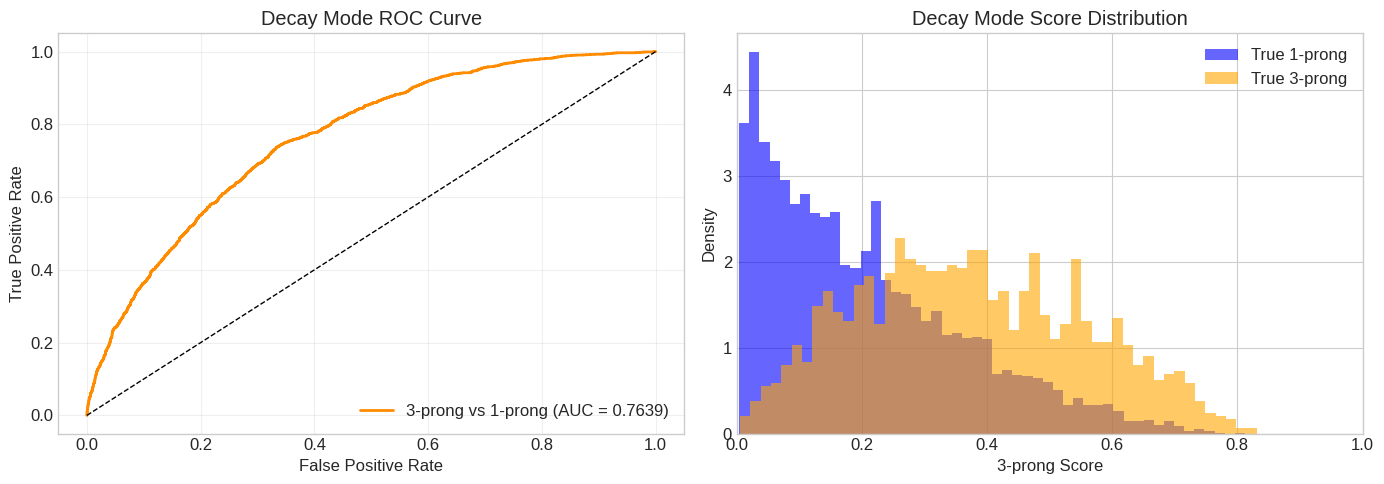


Decay Mode AUC: 0.7639


In [8]:
# Decay mode ROC and score distributions
if 'aux_decay_mode_pred' in data.keys():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # ROC curve for 3-prong vs 1-prong
    y_true_3prong = (dm_true_valid == 1).astype(int)
    score_3prong = dm_pred_valid[:, 1]  # Probability of being 3-prong
    
    fpr_dm, tpr_dm, _ = roc_curve(y_true_3prong, score_3prong)
    auc_dm = auc(fpr_dm, tpr_dm)
    
    axes[0].plot(fpr_dm, tpr_dm, 'darkorange', lw=2, label=f'3-prong vs 1-prong (AUC = {auc_dm:.4f})')
    axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Decay Mode ROC Curve')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # Score distributions
    axes[1].hist(score_3prong[dm_true_valid == 0], bins=50, alpha=0.6, 
                 label='True 1-prong', color='blue', density=True)
    axes[1].hist(score_3prong[dm_true_valid == 1], bins=50, alpha=0.6, 
                 label='True 3-prong', color='orange', density=True)
    axes[1].set_xlabel('3-prong Score')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Decay Mode Score Distribution')
    axes[1].legend()
    axes[1].set_xlim([0, 1])
    
    plt.tight_layout()
    plt.savefig('../results/decay_mode_roc.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nDecay Mode AUC: {auc_dm:.4f}")

## 10. Electron vs QCD Auxiliary Task

This auxiliary task directly classifies electrons from QCD (only for electron and QCD jets).

Electron vs QCD samples: 17763
  QCD jets: 15191
  Electron jets: 2572


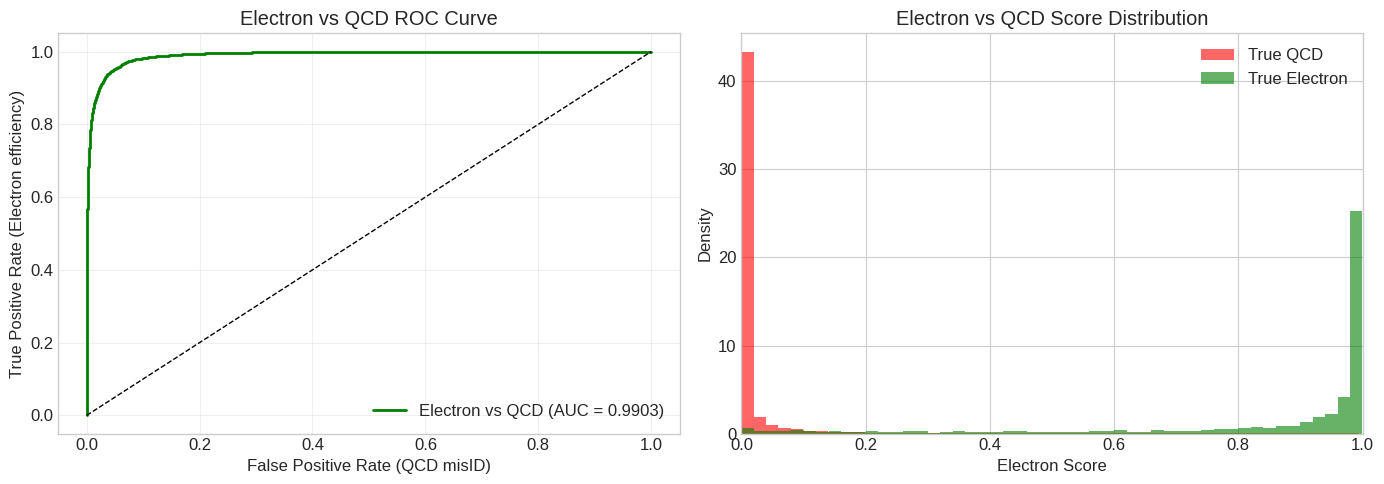


Electron vs QCD AUC: 0.9903


In [9]:
# Electron vs QCD auxiliary task
if 'aux_electron_vs_qcd_pred' in data.keys():
    evq_pred = data['aux_electron_vs_qcd_pred']  # Shape: [N_jets, 2]
    
    # Filter for electron and QCD jets only
    evq_mask = (true_labels == 0) | (true_labels == 2)  # QCD=0, Electron=2
    evq_pred_valid = evq_pred[evq_mask]
    evq_true = (true_labels[evq_mask] == 2).astype(int)  # Electron=1, QCD=0
    
    print(f"Electron vs QCD samples: {evq_mask.sum()}")
    print(f"  QCD jets: {(true_labels[evq_mask] == 0).sum()}")
    print(f"  Electron jets: {(true_labels[evq_mask] == 2).sum()}")
    
    # ROC curve
    evq_score = evq_pred_valid[:, 1]  # Probability of being electron
    fpr_evq, tpr_evq, _ = roc_curve(evq_true, evq_score)
    auc_evq = auc(fpr_evq, tpr_evq)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(fpr_evq, tpr_evq, 'green', lw=2, label=f'Electron vs QCD (AUC = {auc_evq:.4f})')
    axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
    axes[0].set_xlabel('False Positive Rate (QCD misID)')
    axes[0].set_ylabel('True Positive Rate (Electron efficiency)')
    axes[0].set_title('Electron vs QCD ROC Curve')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # Score distribution
    axes[1].hist(evq_score[evq_true == 0], bins=50, alpha=0.6, 
                 label='True QCD', color='red', density=True)
    axes[1].hist(evq_score[evq_true == 1], bins=50, alpha=0.6, 
                 label='True Electron', color='green', density=True)
    axes[1].set_xlabel('Electron Score')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Electron vs QCD Score Distribution')
    axes[1].legend()
    axes[1].set_xlim([0, 1])
    
    plt.tight_layout()
    plt.savefig('../results/electron_vs_qcd.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nElectron vs QCD AUC: {auc_evq:.4f}")
else:
    print("No electron_vs_qcd auxiliary predictions found.")

## 11. All Tasks Summary

In [10]:
# Final summary of all tasks
print("=" * 60)
print("MULTI-TASK LEARNING SUMMARY")
print("=" * 60)

# Primary task
print("\n[PRIMARY TASK] Tau vs QCD vs Electron (3-class)")
print(f"  Overall Accuracy: {accuracy:.4f}")
tau_qcd_mask = (true_labels == 0) | (true_labels == 1)
tau_score = predictions[tau_qcd_mask, 1]
is_tau = (true_labels[tau_qcd_mask] == 1).astype(int)
fpr, tpr, _ = roc_curve(is_tau, tau_score)
print(f"  Tau vs QCD AUC: {auc(fpr, tpr):.4f}")

# Auxiliary task 1: Decay mode
if 'aux_decay_mode_pred' in data.keys():
    print("\n[AUXILIARY TASK 1] Decay Mode (1-prong vs 3-prong)")
    print(f"  Accuracy: {dm_accuracy:.4f}")
    print(f"  AUC: {auc_dm:.4f}")
    print(f"  Evaluated on: {valid_mask.sum()} tau jets")
else:
    print("\n[AUXILIARY TASK 1] Decay Mode - Not available")

# Auxiliary task 2: Electron vs QCD
if 'aux_electron_vs_qcd_pred' in data.keys():
    evq_acc = accuracy_score(evq_true, (evq_score > 0.5).astype(int))
    print("\n[AUXILIARY TASK 2] Electron vs QCD")
    print(f"  Accuracy: {evq_acc:.4f}")
    print(f"  AUC: {auc_evq:.4f}")
    print(f"  Evaluated on: {evq_mask.sum()} jets")
else:
    print("\n[AUXILIARY TASK 2] Electron vs QCD - Not available")

print("\n" + "=" * 60)

MULTI-TASK LEARNING SUMMARY

[PRIMARY TASK] Tau vs QCD vs Electron (3-class)
  Overall Accuracy: 0.7673
  Tau vs QCD AUC: 0.8318

[AUXILIARY TASK 1] Decay Mode (1-prong vs 3-prong)
  Accuracy: 0.7622
  AUC: 0.7639
  Evaluated on: 6658 tau jets

[AUXILIARY TASK 2] Electron vs QCD
  Accuracy: 0.9670
  AUC: 0.9903
  Evaluated on: 17763 jets



## 4. Confusion Matrix

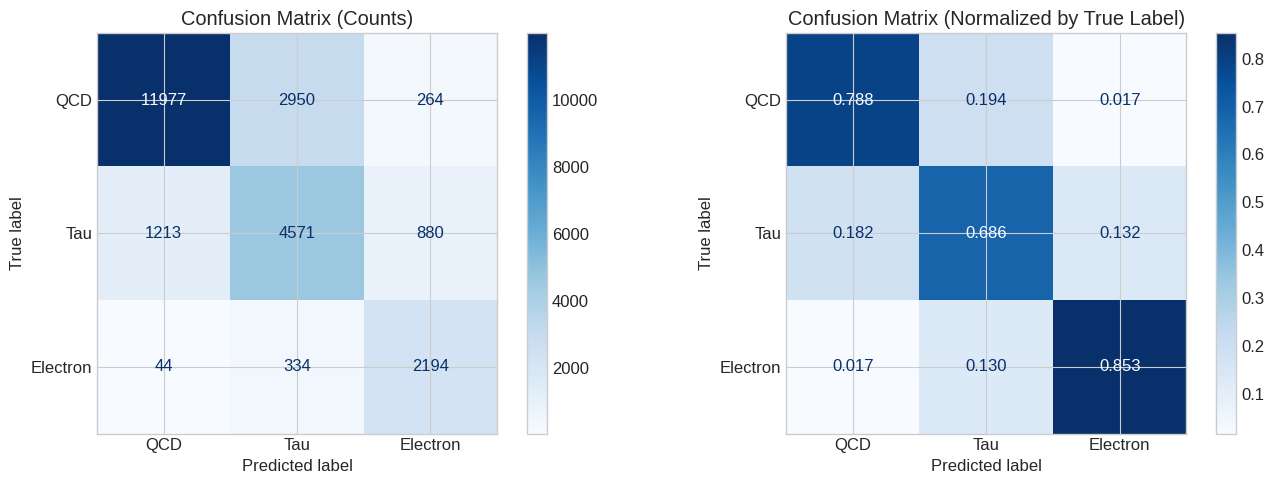

In [11]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
disp1 = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized (row-wise = recall)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp2 = ConfusionMatrixDisplay(cm_norm, display_labels=class_names)
disp2.plot(ax=axes[1], cmap='Blues', values_format='.3f')
axes[1].set_title('Confusion Matrix (Normalized by True Label)')

plt.tight_layout()
plt.savefig('../results/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. ROC Curves

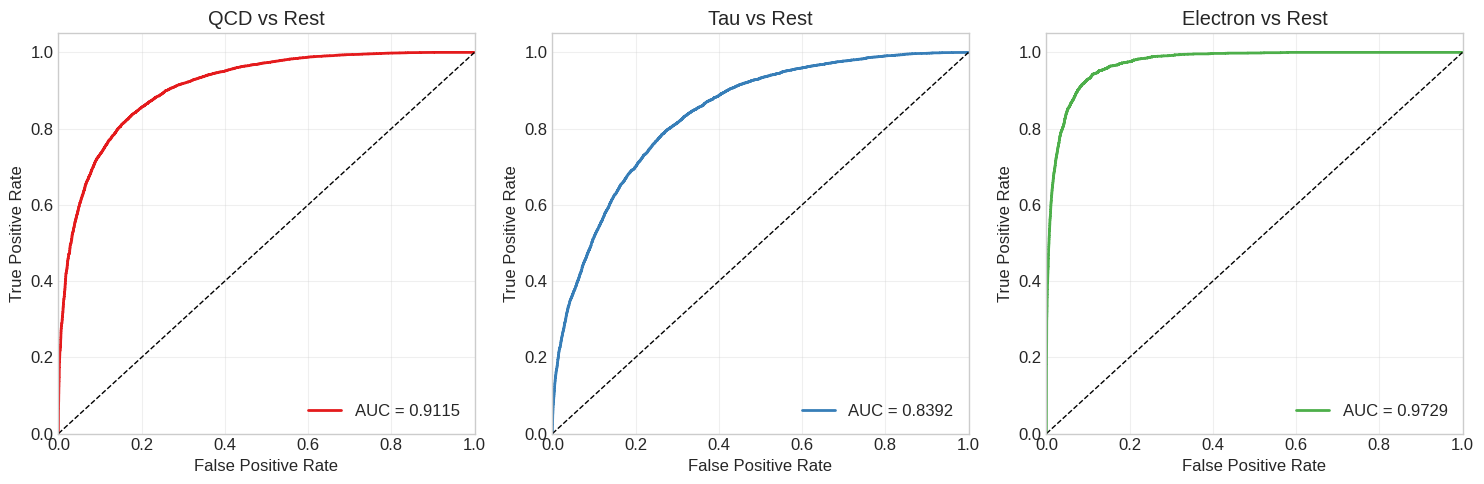

In [12]:
# ROC curves for each class (one-vs-rest)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = ['#e41a1c', '#377eb8', '#4daf4a']  # Red, Blue, Green

for i, (name, color) in enumerate(zip(class_names, colors)):
    # Binary labels for this class
    y_true_binary = (true_labels == i).astype(int)
    y_score = predictions[:, i]
    
    # Compute ROC
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    axes[i].plot(fpr, tpr, color=color, lw=2, label=f'AUC = {roc_auc:.4f}')
    axes[i].plot([0, 1], [0, 1], 'k--', lw=1)
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'{name} vs Rest')
    axes[i].legend(loc='lower right')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Tau vs QCD (Primary Task)

/tmp/ipykernel_1294325/2455897733.py:28: RuntimeWarning: divide by zero encountered in divide
  rejection = np.where(fpr > 0, 1.0 / fpr, np.inf)


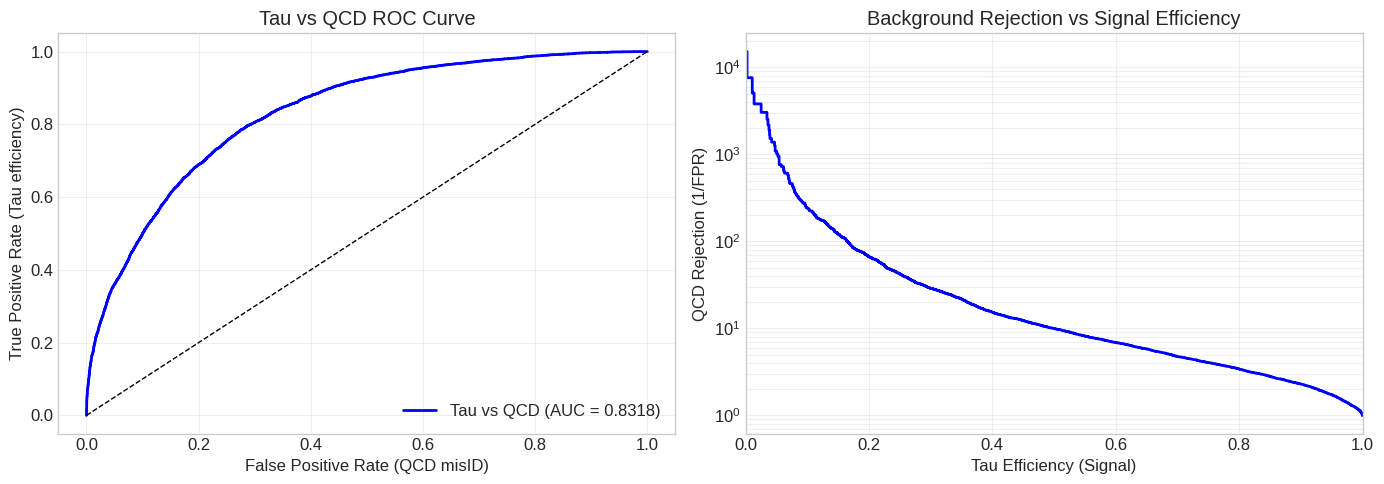


Working points (Tau efficiency -> QCD rejection):
  50% Tau eff -> 10.0x QCD rejection
  60% Tau eff -> 6.9x QCD rejection
  70% Tau eff -> 4.8x QCD rejection
  80% Tau eff -> 3.4x QCD rejection
  90% Tau eff -> 2.3x QCD rejection


In [13]:
# Focus on Tau vs QCD (the primary physics task)
# Select only tau and QCD jets
tau_qcd_mask = (true_labels == 0) | (true_labels == 1)
tau_qcd_labels = true_labels[tau_qcd_mask]
tau_qcd_probs = predictions[tau_qcd_mask]

# Tau probability (score for being tau)
tau_score = tau_qcd_probs[:, 1]
is_tau = (tau_qcd_labels == 1).astype(int)

# ROC curve
fpr, tpr, thresholds = roc_curve(is_tau, tau_score)
roc_auc = auc(fpr, tpr)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC curve
axes[0].plot(fpr, tpr, 'b-', lw=2, label=f'Tau vs QCD (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0].set_xlabel('False Positive Rate (QCD misID)')
axes[0].set_ylabel('True Positive Rate (Tau efficiency)')
axes[0].set_title('Tau vs QCD ROC Curve')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Background rejection vs signal efficiency
# Avoid division by zero
rejection = np.where(fpr > 0, 1.0 / fpr, np.inf)
valid = rejection < 1e6  # Filter out infinite values

axes[1].semilogy(tpr[valid], rejection[valid], 'b-', lw=2)
axes[1].set_xlabel('Tau Efficiency (Signal)')
axes[1].set_ylabel('QCD Rejection (1/FPR)')
axes[1].set_title('Background Rejection vs Signal Efficiency')
axes[1].grid(True, alpha=0.3, which='both')
axes[1].set_xlim([0, 1])

plt.tight_layout()
plt.savefig('../results/tau_vs_qcd.png', dpi=150, bbox_inches='tight')
plt.show()

# Print some working points
print("\nWorking points (Tau efficiency -> QCD rejection):")
for target_eff in [0.5, 0.6, 0.7, 0.8, 0.9]:
    idx = np.argmin(np.abs(tpr - target_eff))
    if fpr[idx] > 0:
        print(f"  {target_eff*100:.0f}% Tau eff -> {1/fpr[idx]:.1f}x QCD rejection")

## 7. Score Distributions

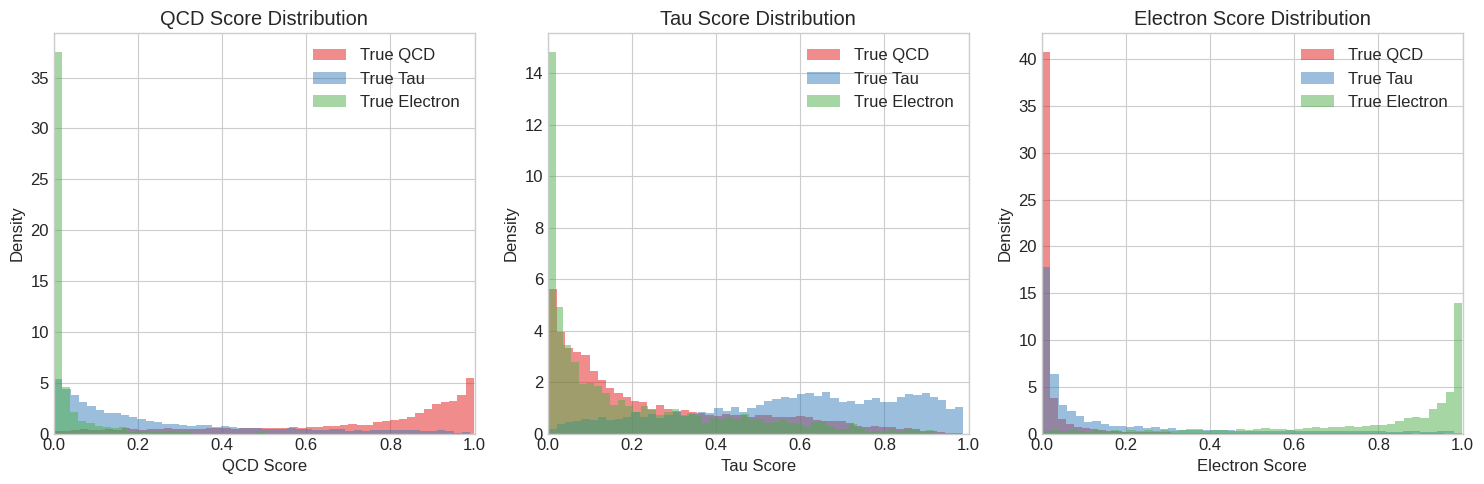

In [14]:
# Plot score distributions for each true class
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, name in enumerate(class_names):
    ax = axes[i]
    
    # Score for this class
    score = predictions[:, i]
    
    # Plot distribution for each true class
    for j, (true_name, color) in enumerate(zip(class_names, colors)):
        mask = true_labels == j
        ax.hist(score[mask], bins=50, alpha=0.5, label=f'True {true_name}', 
                color=color, density=True)
    
    ax.set_xlabel(f'{name} Score')
    ax.set_ylabel('Density')
    ax.set_title(f'{name} Score Distribution')
    ax.legend()
    ax.set_xlim([0, 1])

plt.tight_layout()
plt.savefig('../results/score_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Summary Statistics

In [15]:
# Summary
print("=" * 50)
print("SUMMARY")
print("=" * 50)
print(f"Total jets evaluated: {len(true_labels)}")
print(f"Overall accuracy: {accuracy:.4f}")
print()

# AUC for each class
print("AUC scores (one-vs-rest):")
for i, name in enumerate(class_names):
    y_true_binary = (true_labels == i).astype(int)
    y_score = predictions[:, i]
    fpr, tpr, _ = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)
    print(f"  {name}: {roc_auc:.4f}")

print()
print("Tau vs QCD (primary task):")
tau_qcd_mask = (true_labels == 0) | (true_labels == 1)
tau_score = predictions[tau_qcd_mask, 1]
is_tau = (true_labels[tau_qcd_mask] == 1).astype(int)
fpr, tpr, _ = roc_curve(is_tau, tau_score)
print(f"  AUC: {auc(fpr, tpr):.4f}")

SUMMARY
Total jets evaluated: 24427
Overall accuracy: 0.7673

AUC scores (one-vs-rest):
  QCD: 0.9115
  Tau: 0.8392
  Electron: 0.9729

Tau vs QCD (primary task):
  AUC: 0.8318
